In [1]:
import sys 
sys.path.append('../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from NN import  activation_functions, loss_functions
import NN.network as network


/root/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def compare_arrays(A, B):
    return (A - B).sum()

## Layer by Layer Validation
To identify if there is no code broken

In [3]:
from importlib import reload
reload(network)
I = np.array([[0.05, 0.10], [0.05, 0.10]])
W = np.array([[0.15, 0.2, 0.1], [0.25, 0.3, 0.1]])
h1 = network.Layer(2, 3, 'sigmoid', weights=W, bias=0.35, label="H1")
netH, outH =  h1.feed_forward(I)
print(netH)
print(outH)

[[0.3825 0.39   0.365 ]
 [0.3825 0.39   0.365 ]]
[[0.59447593 0.5962827  0.59025025]
 [0.59447593 0.5962827  0.59025025]]


In [4]:
from importlib import reload
reload(network)

W = np.array([[0.4, 0.45], [0.50, 0.55], [0.50, 0.55]])
o1 = network.Layer(3, 2, 'sigmoid', weights=W, bias=0.6, label="H1")
netO, outO =  o1.feed_forward(h1.out)
print(netO)
print(outO)

[[1.43105685 1.52010729]
 [1.43105685 1.52010729]]
[[0.80706593 0.82055428]
 [0.80706593 0.82055428]]


# Convergence Checkings
Based on the sample given by the class teacher

## Manual Calculations

In [5]:
from importlib import reload
reload(network)
model = network.NN(loss='smd')
X = np.array([[0.05, 0.10]])

Wh = np.array([[0.15, 0.2], [0.25, 0.3]])
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = np.array([[0.4, 0.45], [0.50, 0.55]])
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="H1")
model.add_layer(h)
model.add_layer(o)
model.show_weights()

Y, aY = model.feed_forward(X)
Y_, aY_ = ([1.10590597, 1.2249214 ], [0.75136507, 0.77292847])
print("Y\n",Y_)
print("\na(Y)\n",aY_)

assert(compare_arrays(Y, Y_))
assert(compare_arrays(aY, aY_))


Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.2 ]
 [0.25 0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.45]
 [0.5  0.55]]
-------------------------------
Y
 [1.10590597, 1.2249214]

a(Y)
 [0.75136507, 0.77292847]


## Working on the back propagation

In [6]:
from importlib import reload
reload(network)
model.show_weights()
Y = np.array([0.01, 0.99])
Etotal = loss_functions.smd(aY, Y)
print(Etotal)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[0.15 0.2 ]
 [0.25 0.3 ]]
H1      (input=2, neurons=2, activation=sigmoid)
[[0.4  0.45]
 [0.5  0.55]]
-------------------------------
[[0.27895364 0.02470467]]


### Emulating the weights update for the layer O 

## Using the implemented Grad calculation for Layers

In [7]:
reload(loss_functions)
reload(activation_functions)
reload(network)

network.DEBUG = False

X = np.array([[0.05, 0.10], [0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99], [0.01, 0.99]], np.float64)

# Wh = np.array([[0.15, 0.2], [0.25, 0.3]], np.float64).T
h = network.Layer(2, 2, 'sigmoid', bias=0.35, label="H1")

# Wo = np.array([[0.4, 0.45], [0.50, 0.55]],  np.float64).T
o = network.Layer(2, 2, 'sigmoid', weights=Wo, label="O")


for i in range(10):
    netH, outH = h.feed_forward(X)
    netO, outO = o.feed_forward(outH)
    
    Etotal = loss_functions.smd(outO, Y)
    print(Etotal)

print (outO)

[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.1904166  0.06106025]
 [0.1904166  0.06106025]]
[[0.62711685 0.64054257]
 [0.62711685 0.64054257]]


# Testing the model fit pipeline 

Here we are still using micro datasets to make sure the code is runnable.

## SMD as the Loss Function

In [8]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = 0.0000000000000001

h = network.Layer(2, 3, 'sigmoid', bias=0.35, label="H1")
o = network.Layer(3, 2, 'sigmoid', bias=0.6, label="Output")

model = network.NN(loss='smd')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=10000, 
          lr=0.5, epsilon=eps, b_sz=1, 
          print_interval=1000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.1)

Model Weights
-------------------------------
H1      (input=2, neurons=3, activation=sigmoid)
[[ 0.0654305   0.35334332  0.26194273]
 [-0.41644901 -0.08303123 -0.45254594]]
Output  (input=3, neurons=2, activation=sigmoid)
[[-0.19026958  0.23118627]
 [-0.07578762 -0.38469319]
 [-0.3660635   0.68730904]]
-------------------------------
Shuffled
It: 1000 Batch: 2 Epoch 499 Error: 0.05809301 lr: 0.500000 
It: 2000 Batch: 2 Epoch 999 Error: 0.05600153 lr: 0.500000 
It: 3000 Batch: 2 Epoch 1499 Error: 0.05600153 lr: 0.500000 
It: 4000 Batch: 2 Epoch 1999 Error: 0.05600153 lr: 0.500000 
It: 5000 Batch: 2 Epoch 2499 Error: 0.05600153 lr: 0.500000 
It: 6000 Batch: 2 Epoch 2999 Error: 0.05600153 lr: 0.500000 
It: 7000 Batch: 2 Epoch 3499 Error: 0.05600153 lr: 0.500000 
It: 8000 Batch: 2 Epoch 3999 Error: 0.05600153 lr: 0.500000 
It: 9000 Batch: 2 Epoch 4499 Error: 0.05600153 lr: 0.500000 
It: 10000 Batch: 2 Epoch 4999 Error: 0.05600153 lr: 0.500000 
Finished 
 It: 10000 Batch: 2 Epoch 4999 Trai

## Cross Entropy 

In [9]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False
eps = np.finfo(np.float64).eps
X = np.array([[0.05, 0.10]], np.float64)
Y = np.array([[0.01, 0.99]], np.float64)

Wh = None #np.array([[0.15, 0.2], [0.25, 0.3]], np.float64)
h = network.Layer(2, 2, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = None #np.array([[0.4, 0.45], [0.50, 0.55]], np.float64)
o = network.Layer(2, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h)
model.add_layer(o)
model.show_weights()

model.fit(X, Y, max_iter=10000,
          lr=0.1, epsilon=eps, 
          print_interval=2000)

_, Y_ = model.feed_forward(X)

mae = np.absolute(Y - Y_).mean()
print(Y_, mae)
assert(mae < 0.1)

Model Weights
-------------------------------
H1      (input=2, neurons=2, activation=sigmoid)
[[ 0.68832874  0.30912428]
 [-0.61382351 -0.08806763]]
Output  (input=2, neurons=2, activation=sigmoid)
[[ 0.29236174 -0.36831972]
 [-0.61550446  0.62847221]]
-------------------------------
Shuffled
It: 2000 Batch: 1 Epoch 1999 Error: 0.06394380 lr: 0.100000 
It: 4000 Batch: 1 Epoch 3999 Error: 0.05600159 lr: 0.100000 
It: 6000 Batch: 1 Epoch 5999 Error: 0.05600153 lr: 0.100000 
It: 8000 Batch: 1 Epoch 7999 Error: 0.05600153 lr: 0.100000 
It: 10000 Batch: 1 Epoch 9999 Error: 0.05600153 lr: 0.100000 
Finished 
 It: 10000 Batch: 1 Epoch 9999 Train Loss: 0.05600153 lr: 0.100000 
[[0.01 0.99]] 1.0229334740374796e-12


## Assimetrical network

In [10]:
from utils import dataset_helper
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)
network.DEBUG = False

eps = np.finfo(np.float64).eps

X = np.array([[0.05, 0.10], [0.05, 0.10], [0.10, 0.05]], np.float64)
Y = np.array([[0.0, 1], [0.0, 1], [1., 0.]], np.float64)

Wh = None #np.array([[0.15, 0.2, 0.1], [0.25, 0.3, 0.1]], np.float64)
h = network.Layer(2, 3, 'sigmoid', weights=Wh, bias=0.35, label="H1")

Wo = None #np.array([[0.4, 0.45], [0.50, 0.55], [0.50, 0.55]], np.float64)
o = network.Layer(3, 2, 'sigmoid', weights=Wo, bias=0.6, label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h)
model.add_layer(o)
model.show_weights()


model.fit(X, Y, max_iter=50000, 
          lr=0.09, epsilon=eps,
          print_interval=2000)

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
Y = Y.argmax(axis=-1)
mae = np.absolute(Y - Y_).mean()
print(mae)
print(Y, Y_)
assert(mae < 0.1)

Model Weights
-------------------------------
H1      (input=2, neurons=3, activation=sigmoid)
[[ 0.5021019  -0.38029606 -0.20453633]
 [-0.3782644  -0.25173108  0.57150496]]
Output  (input=3, neurons=2, activation=sigmoid)
[[0.4843069  0.4193879 ]
 [0.45733423 0.04293407]
 [0.46781566 0.074643  ]]
-------------------------------
Shuffled
It: 2000 Batch: 2 Epoch 666 Error: 0.65551336 lr: 0.090000 
It: 4000 Batch: 1 Epoch 1333 Error: 0.64601661 lr: 0.090000 
It: 6000 Batch: 3 Epoch 1999 Error: 0.62068276 lr: 0.090000 
It: 8000 Batch: 2 Epoch 2666 Error: 0.50609907 lr: 0.090000 
It: 10000 Batch: 1 Epoch 3333 Error: 0.25496449 lr: 0.090000 
It: 12000 Batch: 3 Epoch 3999 Error: 0.09660868 lr: 0.090000 
It: 14000 Batch: 2 Epoch 4666 Error: 0.04730791 lr: 0.090000 
It: 16000 Batch: 1 Epoch 5333 Error: 0.02899940 lr: 0.090000 
It: 18000 Batch: 3 Epoch 5999 Error: 0.02024516 lr: 0.090000 
It: 20000 Batch: 2 Epoch 6666 Error: 0.01526424 lr: 0.090000 
It: 22000 Batch: 1 Epoch 7333 Error: 0.012123

# Multi class Classification Test

In [11]:
nclasses = 3
nsamples = 60000
nfeatures = 128

eps = np.finfo(np.float128).eps


vals = dataset_helper.get_toy_data_multiclass(nclasses, nsamples, nfeatures)
X,  _, _, _ = vals

epoch_sz = X.shape[0]
lr = 0.5
max_iter = 5 * epoch_sz
print_interval = 20*1000
decay_iteractions= 1 * epoch_sz
decay_rate = 0.5

## Using Cross Entropy as the Loss Function

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=tanh)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.21113726 lr: 0.500000 Val Loss: 1.28454230 Val Acc 0.84441667
It: 40000 Batch: 40000 Epoch 0 Train Loss: 1.03235027 lr: 0.500000 Val Loss: 1.16430444 Val Acc 0.85666667
It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.74023668 lr: 0.250000 Val Loss: 0.75115859 Val Acc 0.86050000
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.49009469 lr: 0.250000 Val Loss: 0.51143837 Val Acc 0.86241667
It: 100000 Batch: 4000 Epoch 2 Train Loss: 0.47121186 lr: 0.125000 Val Loss: 0.40892807 Val Acc 0.86733333
It: 120000 Batch: 24000 Epoch 2 Train Loss: 0.31522051 lr: 0.125000 Val Loss: 0.45774163 Val Acc 0.78425000
It: 140000 Batch: 44000 Epoch 2 Train Loss: 0.30882544 lr: 0.125000 Val Loss: 0.41727073 Val Acc 0.87791667
It: 160000 Batch: 16000 Epoch 3 Train Loss: 0.26863309 lr: 0.0

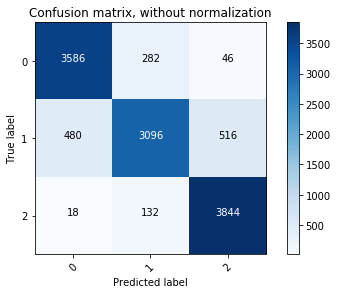

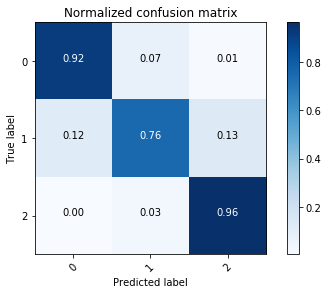

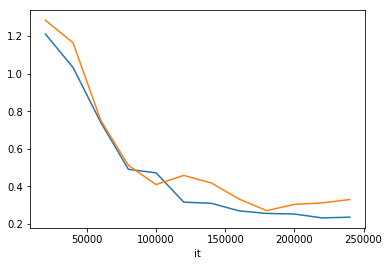

In [12]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'tanh',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=sigmoid)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 1.03433000 lr: 0.500000 Val Loss: 1.27495942 Val Acc 0.80566667
Finished 
 It: 20001 Batch: 20001 Epoch 0 Train Loss: 0.00000000 lr: 0.500000 Val Loss: 1.27495942
6
Time Spent  4.442882274999988
Validation Stats...
Accuracy: 0.806
Precision: 0.816
Recall: 0.805
F1 Score: 0.810382
{0: 0, 1: 1, 2: 2}
Confusion matrix, without normalization
Normalized confusion matrix


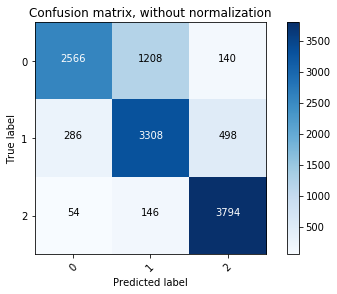

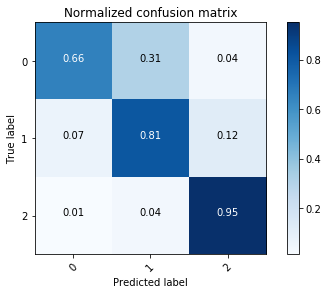

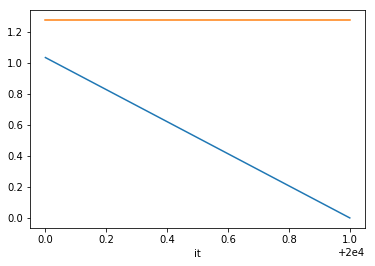

In [13]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

eps = np.finfo(np.float32).eps

h1 = network.Layer(nfeatures, 64, 'sigmoid',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=relu)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 20000 Batch: 20000 Epoch 0 Train Loss: 0.22714519 lr: 0.010000 Val Loss: 0.22389988 Val Acc 0.90133333
It: 40000 Batch: 40000 Epoch 0 Train Loss: 0.18446595 lr: 0.010000 Val Loss: 0.22583244 Val Acc 0.90666667
It: 60000 Batch: 12000 Epoch 1 Train Loss: 0.16795608 lr: 0.005000 Val Loss: 0.18813925 Val Acc 0.92383333
It: 80000 Batch: 32000 Epoch 1 Train Loss: 0.16033427 lr: 0.005000 Val Loss: 0.18837897 Val Acc 0.92816667
It: 100000 Batch: 4000 Epoch 2 Train Loss: 0.15038649 lr: 0.002500 Val Loss: 0.16057691 Val Acc 0.93741667
It: 120000 Batch: 24000 Epoch 2 Train Loss: 0.13597955 lr: 0.002500 Val Loss: 0.16933611 Val Acc 0.94183333
It: 140000 Batch: 44000 Epoch 2 Train Loss: 0.13691305 lr: 0.002500 Val Loss: 0.16517016 Val Acc 0.94141667
It: 160000 Batch: 16000 Epoch 3 Train Loss: 0.12815062 lr: 0.0

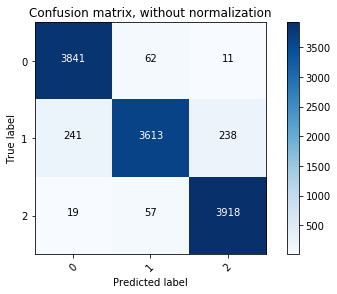

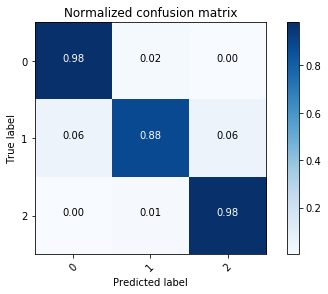

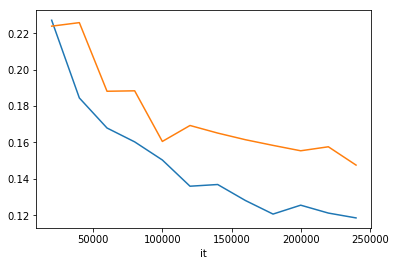

In [14]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)


network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'relu',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()



print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=0.01, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

## Using SMD 

In [15]:
print_interval=100

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=tanh)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 100 Batch: 100 Epoch 0 Train Loss: 0.10584152 lr: 0.500000 Val Loss: 0.08527207 Val Acc 0.69958333
It: 200 Batch: 200 Epoch 0 Train Loss: 0.08953403 lr: 0.500000 Val Loss: 0.07681076 Val Acc 0.72558333
It: 300 Batch: 300 Epoch 0 Train Loss: 0.06271963 lr: 0.500000 Val Loss: 0.07003460 Val Acc 0.75075000
It: 400 Batch: 400 Epoch 0 Train Loss: 0.06587484 lr: 0.500000 Val Loss: 0.06917498 Val Acc 0.75808333
It: 500 Batch: 500 Epoch 0 Train Loss: 0.06825922 lr: 0.500000 Val Loss: 0.06245599 Val Acc 0.78166667
It: 600 Batch: 600 Epoch 0 Train Loss: 0.07000797 lr: 0.500000 Val Loss: 0.06900806 Val Acc 0.75966667
It: 700 Batch: 700 Epoch 0 Train Loss: 0.05655993 lr: 0.500000 Val Loss: 0.06057944 Val Acc 0.78858333
It: 800 Batch: 800 Epoch 0 Train Loss: 0.06307564 lr: 0.500000 Val Loss: 0.06173825 Val Acc 

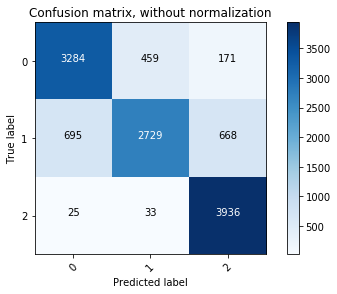

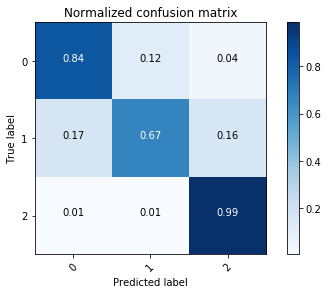

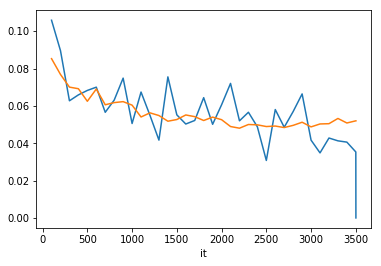

In [16]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'tanh',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=sigmoid)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 100 Batch: 100 Epoch 0 Train Loss: 0.09959851 lr: 0.500000 Val Loss: 0.07739501 Val Acc 0.69091667
It: 200 Batch: 200 Epoch 0 Train Loss: 0.07803112 lr: 0.500000 Val Loss: 0.06844918 Val Acc 0.74008333
Finished 
 It: 201 Batch: 201 Epoch 0 Train Loss: 0.00012240 lr: 0.500000 Val Loss: 0.06844918
6
Time Spent  1.7386817269999995
Validation Stats...
Accuracy: 0.740
Precision: 0.764
Recall: 0.741
F1 Score: 0.751943
{0: 0, 1: 1, 2: 2}
Confusion matrix, without normalization
Normalized confusion matrix


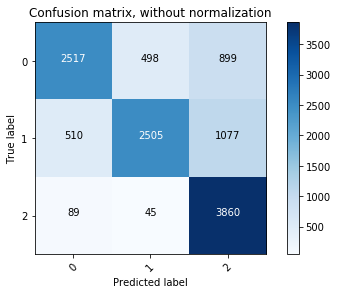

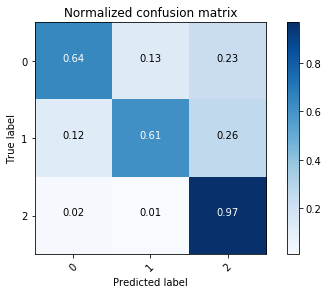

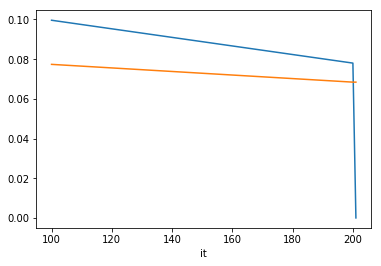

In [17]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'sigmoid',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=0.001, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=relu)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 100 Batch: 100 Epoch 0 Train Loss: 0.11988322 lr: 0.500000 Val Loss: 0.10002681 Val Acc 0.66633333
Finished 
 It: 101 Batch: 101 Epoch 0 Train Loss: 0.00000000 lr: 0.500000 Val Loss: 0.10002681
6
Time Spent  0.8520309870000062
Validation Stats...
Accuracy: 0.666
Precision: 0.671
Recall: 0.666
F1 Score: 0.668211
{0: 0, 1: 1, 2: 2}
Confusion matrix, without normalization
Normalized confusion matrix


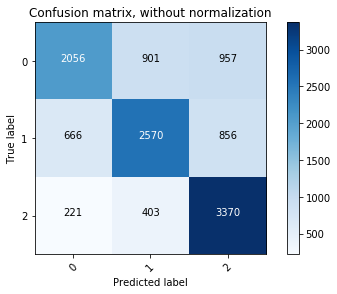

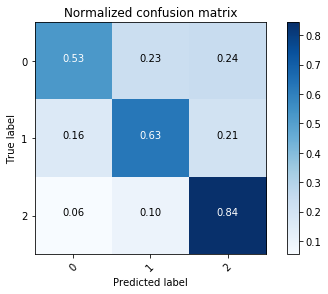

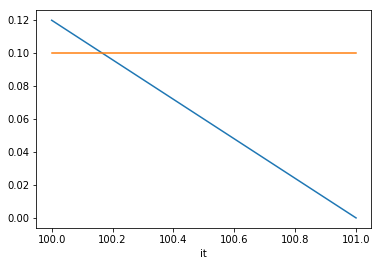

In [18]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)

network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'relu',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='smd')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = 1,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores
custom_scores.evalute_multiclass(Y_val.argmax(axis=-1), Y_val_.argmax(axis=-1))
iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

## Batch Update Tests

In [19]:
lr = 0.1
b_sz = 128
decay_iteractions = 1 * (epoch_sz // b_sz) 
max_iter = 5 * (epoch_sz // b_sz) 
print_interval = (epoch_sz // b_sz) 

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=tanh)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 375 Batch: 375 Epoch 0 Train Loss: 2.24897809 lr: 0.100000 Val Loss: 2.67190371 Val Acc 0.75958333
It: 750 Batch: 375 Epoch 1 Train Loss: 0.92854219 lr: 0.050000 Val Loss: 1.43931369 Val Acc 0.77966667
It: 1125 Batch: 375 Epoch 2 Train Loss: 0.44519705 lr: 0.025000 Val Loss: 0.47131247 Val Acc 0.84441667
It: 1500 Batch: 375 Epoch 3 Train Loss: 0.27678623 lr: 0.012500 Val Loss: 0.31065589 Val Acc 0.86041667
It: 1875 Batch: 375 Epoch 4 Train Loss: 0.25320717 lr: 0.006250 Val Loss: 0.29563852 Val Acc 0.86958333
Finished 
 It: 1875 Batch: 375 Epoch 4 Train Loss: 0.25320717 lr: 0.006250 Val Loss: 0.29563852
6
Time Spent  28.088651490000018


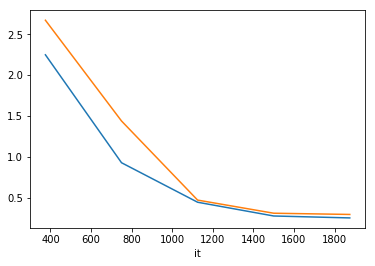

In [20]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)



network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'tanh',  label="H1")
o = network.Layer(64, nclasses, 'sigmoid', label="Output")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = b_sz,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores

iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=64, activation=relu)
Output  (input=64, neurons=64, activation=sigmoid)
Output  (input=64, neurons=3, activation=sigmoid)
-------------------------------

Shuffled


../NN/activation_functions.py:28: RuntimeWarning: overflow encountered in exp
  sig = 1. / (1. + np.exp(-h))


It: 375 Batch: 375 Epoch 0 Train Loss: 13.28093158 lr: 0.100000 Val Loss: 14.33210595 Val Acc 0.35041667
It: 750 Batch: 375 Epoch 1 Train Loss: 10.39784742 lr: 0.050000 Val Loss: 15.17319594 Val Acc 0.34100000
It: 1125 Batch: 375 Epoch 2 Train Loss: 7.91352011 lr: 0.025000 Val Loss: 15.17421141 Val Acc 0.34100000
It: 1500 Batch: 375 Epoch 3 Train Loss: 7.79917472 lr: 0.012500 Val Loss: 15.17421141 Val Acc 0.34100000
It: 1875 Batch: 375 Epoch 4 Train Loss: 7.79068811 lr: 0.006250 Val Loss: 15.17421141 Val Acc 0.34100000
Finished 
 It: 1875 Batch: 375 Epoch 4 Train Loss: 7.79068811 lr: 0.006250 Val Loss: 15.17421141
6
Time Spent  33.24308019


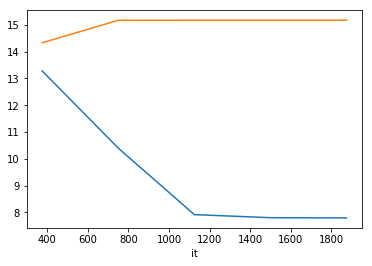

In [21]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)



network.DEBUG = False

h1 = network.Layer(nfeatures, 64, 'relu',  label="H1")
o = network.Layer(64, 64, 'sigmoid', label="Output")
o1 = network.Layer(64, nclasses, 'sigmoid', label="Output")


model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(o)
model.add_layer(o1)
model.summary()


print("")
start = time.process_time()
model.fit(X, Y, max_iter=max_iter, 
          lr=lr, epsilon=eps, b_sz = b_sz,
          decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores

iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()

Model Summary
-------------------------------
H1      (input=128, neurons=128, activation=sigmoid)
H2      (input=128, neurons=128, activation=sigmoid)
soft    (input=128, neurons=3, activation=sigmoid)
-------------------------------

Shuffled
It: 375 Batch: 375 Epoch 0 Train Loss: 0.62876245 lr: 0.000100 Val Loss: 0.59598416 Val Acc 0.68875000
It: 750 Batch: 750 Epoch 0 Train Loss: 0.59360836 lr: 0.000100 Val Loss: 0.54563911 Val Acc 0.74425000
It: 1125 Batch: 375 Epoch 1 Train Loss: 0.55244363 lr: 0.000100 Val Loss: 0.47618073 Val Acc 0.79741667
It: 1500 Batch: 750 Epoch 1 Train Loss: 0.49802959 lr: 0.000100 Val Loss: 0.39973156 Val Acc 0.81600000
It: 1875 Batch: 375 Epoch 2 Train Loss: 0.44284991 lr: 0.000100 Val Loss: 0.33811041 Val Acc 0.82566667
It: 2250 Batch: 750 Epoch 2 Train Loss: 0.38960070 lr: 0.000100 Val Loss: 0.29435756 Val Acc 0.83566667
It: 2625 Batch: 375 Epoch 3 Train Loss: 0.35760138 lr: 0.000100 Val Loss: 0.26935865 Val Acc 0.84416667
It: 3000 Batch: 750 Epoch 3 T

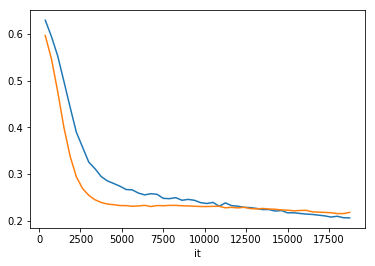

In [22]:
import time
import timeit
from utils import dataset_helper
from utils import custom_scores
reload(custom_scores)
reload(dataset_helper)
reload(loss_functions)
reload(activation_functions)
reload(network)
reload(dataset_helper)

X,  X_val, Y, Y_val = vals
Y = dataset_helper.one_hot_encode(Y, nclasses)
Y_val = dataset_helper.one_hot_encode(Y_val, nclasses)



network.DEBUG = False

h1 = network.Layer(nfeatures, 128, 'sigmoid',  label="H1")
h2 = network.Layer(128, 128, 'sigmoid',  label="H2")
o1 = network.Layer(128, nclasses, 'sigmoid', label="soft")

model = network.NN(loss='cross_entropy')
model.add_layer(h1)
model.add_layer(h2)
# model.add_layer(o)
model.add_layer(o1)
model.summary()

print("")
start = time.process_time()
model.fit(X, Y, max_iter=10*max_iter, 
          lr=0.0001, epsilon=eps, b_sz = 64,
#           decay_iteractions= decay_iteractions, decay_rate = decay_rate,
          X_val=X_val, Y_val=Y_val,
          print_interval=print_interval)
iteraction_log = network.get_iteration_log()

Y_ = np.array(model.predict(X))
Y_ = Y_.argmax(axis=-1)
mae = np.absolute(Y.argmax(axis=-1) - Y_).mean()

print("Time Spent ", time.process_time() - start)


Y_val_ = np.array(model.predict(X_val))


import time
import timeit
from utils import dataset_helper
from utils import custom_scores

iteraction_log.index = iteraction_log.it
iteraction_log.error_train.plot()
iteraction_log.error_val.plot()